In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA/Common/')

In [3]:
%matplotlib inline
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

In [4]:
from models import *
from utils import *
from data_loaders import *
from train import *
import validation as test
from graph import *
from albumentation import *
from albumentations import Normalize, HorizontalFlip, VerticalFlip, Rotate, Cutout, PadIfNeeded, RandomCrop, Flip
from gradCAM import *
from lr_finder import *
from torch.utils.data import DataLoader

  pip install torch-lr-finder -v --global-option="amp"


In [5]:
BATCH_SIZE = 256
EPOCHS = 50
device = getDevice()
dataloader_args = getDataLoaderArgs(BATCH_SIZE)

mean = [0.5,0.5,0.5]
std = [0.278, 0.278, 0.278]
train_data_transforms_list = [Normalize(mean=mean, std=std),
                              PadIfNeeded(min_height=72, min_width=72, border_mode=cv2.BORDER_CONSTANT, value=0), 
                              RandomCrop(64, 64),
                              Cutout(num_holes=1, max_h_size=16, max_w_size=16),
                              HorizontalFlip()
                                ]     
train_data_transfomrs = getAlbumTransformation(train_data_transforms_list)

test_data_transforms_list = [Normalize(mean=mean, std=std)]
test_data_transfomrs = getAlbumTransformation(test_data_transforms_list)

train_dataset, test_dataset, classIds = get_tiny_imagenet_dataset(train_split = 70,test_transforms = test_data_transfomrs,train_transforms = train_data_transfomrs)
trainloader = getTrainDataLoader("TINY_IMAGENET", dataloader_args, train_data_transfomrs, train_dataset)
testloader = getTestDataLoader("TINY_IMAGENET", dataloader_args, test_data_transfomrs, test_dataset)

CUDA Available? True
Images already downloaded...


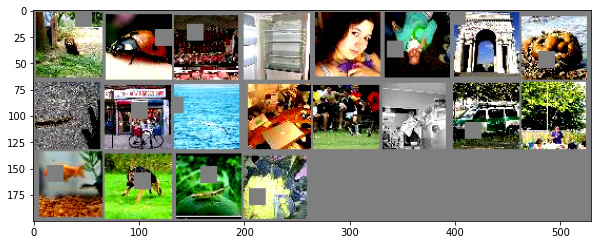

In [6]:
showFewDataSetImages(trainloader, 20)
classes = getTinyImageNetWordClasses('tiny-imagenet-200/words.txt',classIds)

In [7]:
model = ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

In [ ]:
print(len(train_dataset), len(test_dataset))
print(classes)
print(len(trainloader))

77000 33000
['Egyptian cat', 'reel', 'volleyball', 'rocking chair, rocker', 'lemon', 'bullfrog, Rana catesbeiana', 'basketball', 'cliff, drop, drop-off', 'espresso', "plunger, plumber's helper", 'parking meter', 'German shepherd, German shepherd dog, German police dog, alsatian', 'dining table, board', 'monarch, monarch butterfly, milkweed butterfly, Danaus plexippus', 'brown bear, bruin, Ursus arctos', 'school bus', 'pizza, pizza pie', 'guinea pig, Cavia cobaya', 'umbrella', 'organ, pipe organ', 'oboe, hautboy, hautbois', 'maypole', 'goldfish, Carassius auratus', 'potpie', 'hourglass', 'seashore, coast, seacoast, sea-coast', 'computer keyboard, keypad', 'Arabian camel, dromedary, Camelus dromedarius', 'ice cream, icecream', 'nail', 'space heater', 'cardigan', 'baboon', 'snail', 'coral reef', 'albatross, mollymawk', "spider web, spider's web", 'sea cucumber, holothurian', 'backpack, back pack, knapsack, packsack, rucksack, haversack', 'Labrador retriever', 'pretzel', 'king penguin, Apt


Learning rate search finished. See the graph with {finder_name}.plot()
Best LR :  0.08170225485575228
Best Acc :  14.84375


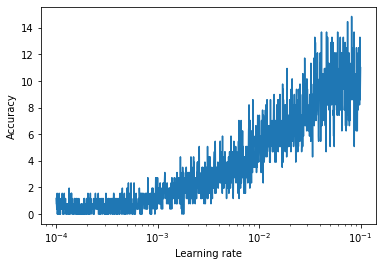

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, weight_decay=1e-4)

epoch = 5
stepsPerEpoch = len(trainloader)
iterations = epoch * stepsPerEpoch

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, start_lr=0.0001, end_lr=0.1, num_iter=iterations, accuracy=True)
print('Best LR : ', lr_finder.history['lr'][lr_finder.history['accuracy'].index(lr_finder.best_acc)])
print('Best Acc : ',lr_finder.best_acc)
lr_finder.plot_acc()
lr_finder.reset()

In [9]:
!mkdir savedModels
import torch
modelName = 'tinyimagenet_resnet18'

mkdir: cannot create directory ‘savedModels’: File exists


In [ ]:
from torch.optim.lr_scheduler import OneCycleLR
max_lr = 0.081
div_factor = 8
min_lr = max_lr/div_factor
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, weight_decay=0.001)
scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(trainloader), epochs=EPOCHS, pct_start=0.5, div_factor=div_factor, final_div_factor=1, anneal_strategy='linear',
                       cycle_momentum=False)
all_train_acc = []


for epoch in range(EPOCHS):
  print('EPOCH : ', epoch, ' LR : ', scheduler.get_lr())
  train(model, device, trainloader, optimizer, criterion, scheduler=scheduler)
  all_train_acc.append(train_acc[-1])
  test.__test(model, device, testloader, criterion)
  if(epoch%5 == 0):
    torch.save(model.state_dict(), "./savedModels/"+modelName+".pt")

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH :  0  LR :  [0.010125]


Loss=4.094008922576904 Batch_id=300 Accuracy=7.59: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 3338/33000 (10.12%)

EPOCH :  1  LR :  [0.012960376794258373]


Loss=3.4280221462249756 Batch_id=300 Accuracy=17.09: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0147, Accuracy: 5664/33000 (17.16%)

EPOCH :  2  LR :  [0.01579575358851675]


Loss=3.329427719116211 Batch_id=300 Accuracy=23.76: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0145, Accuracy: 6013/33000 (18.22%)

EPOCH :  3  LR :  [0.01863113038277512]


Loss=2.9899230003356934 Batch_id=300 Accuracy=28.87: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 7475/33000 (22.65%)

EPOCH :  4  LR :  [0.021466507177033495]


Loss=2.6691980361938477 Batch_id=300 Accuracy=32.91: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 9054/33000 (27.44%)

EPOCH :  5  LR :  [0.02430188397129187]


Loss=2.8942928314208984 Batch_id=300 Accuracy=36.21: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0148, Accuracy: 7250/33000 (21.97%)

EPOCH :  6  LR :  [0.027137260765550238]


Loss=2.607430934906006 Batch_id=300 Accuracy=38.79: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 9562/33000 (28.98%)

EPOCH :  7  LR :  [0.02997263755980862]


Loss=2.413865566253662 Batch_id=300 Accuracy=41.21: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 11484/33000 (34.80%)

EPOCH :  8  LR :  [0.03280801435406699]


Loss=2.2499985694885254 Batch_id=300 Accuracy=43.26: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 11683/33000 (35.40%)

EPOCH :  9  LR :  [0.03564339114832536]


Loss=2.10506272315979 Batch_id=300 Accuracy=45.26: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 10574/33000 (32.04%)

EPOCH :  10  LR :  [0.03847876794258374]


Loss=2.1041512489318848 Batch_id=300 Accuracy=46.36: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0105, Accuracy: 12320/33000 (37.33%)

EPOCH :  11  LR :  [0.04131414473684211]


Loss=1.958176612854004 Batch_id=300 Accuracy=48.12: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 11596/33000 (35.14%)

EPOCH :  12  LR :  [0.04414952153110048]


Loss=2.2725281715393066 Batch_id=300 Accuracy=49.49: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 11669/33000 (35.36%)

EPOCH :  13  LR :  [0.04698489832535886]


Loss=1.8720219135284424 Batch_id=300 Accuracy=50.25: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 12155/33000 (36.83%)

EPOCH :  14  LR :  [0.04982027511961724]


Loss=2.179287910461426 Batch_id=300 Accuracy=50.95: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 11256/33000 (34.11%)

EPOCH :  15  LR :  [0.052655651913875605]


Loss=2.058130979537964 Batch_id=300 Accuracy=51.23: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0106, Accuracy: 12244/33000 (37.10%)

EPOCH :  16  LR :  [0.05549102870813398]


Loss=2.161363363265991 Batch_id=300 Accuracy=51.66: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 13511/33000 (40.94%)

EPOCH :  17  LR :  [0.058326405502392355]


Loss=1.9382091760635376 Batch_id=300 Accuracy=52.04: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 12897/33000 (39.08%)

EPOCH :  18  LR :  [0.06116178229665073]


Loss=1.9549297094345093 Batch_id=300 Accuracy=52.58: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 11976/33000 (36.29%)

EPOCH :  19  LR :  [0.0639971590909091]


Loss=1.8957889080047607 Batch_id=300 Accuracy=52.68: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 11501/33000 (34.85%)

EPOCH :  20  LR :  [0.06683253588516747]


Loss=1.847312569618225 Batch_id=300 Accuracy=52.88: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 12761/33000 (38.67%)

EPOCH :  21  LR :  [0.06966791267942585]


Loss=2.058695077896118 Batch_id=300 Accuracy=52.94: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 11053/33000 (33.49%)

EPOCH :  22  LR :  [0.07250328947368422]


Loss=2.0100040435791016 Batch_id=300 Accuracy=52.71: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 13388/33000 (40.57%)

EPOCH :  23  LR :  [0.07533866626794258]


Loss=1.767508864402771 Batch_id=300 Accuracy=53.09: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0108, Accuracy: 12241/33000 (37.09%)

EPOCH :  24  LR :  [0.07817404306220095]


Loss=1.9849557876586914 Batch_id=300 Accuracy=52.94: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 12606/33000 (38.20%)

EPOCH :  25  LR :  [0.08099058139534884]


Loss=1.8846516609191895 Batch_id=300 Accuracy=53.33: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 11583/33000 (35.10%)

EPOCH :  26  LR :  [0.07815558139534884]


Loss=1.8599437475204468 Batch_id=300 Accuracy=54.45: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0103, Accuracy: 12758/33000 (38.66%)

EPOCH :  27  LR :  [0.07532058139534883]


Loss=1.7316405773162842 Batch_id=300 Accuracy=55.11: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0093, Accuracy: 14276/33000 (43.26%)

EPOCH :  28  LR :  [0.07248558139534884]


Loss=1.5943554639816284 Batch_id=300 Accuracy=56.15: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 13533/33000 (41.01%)

EPOCH :  29  LR :  [0.06965058139534884]


Loss=1.7196317911148071 Batch_id=300 Accuracy=57.25: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 13454/33000 (40.77%)

EPOCH :  30  LR :  [0.06681558139534884]


Loss=1.915543556213379 Batch_id=300 Accuracy=58.12: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0104, Accuracy: 12952/33000 (39.25%)

EPOCH :  31  LR :  [0.06398058139534885]


Loss=1.6761895418167114 Batch_id=300 Accuracy=59.21: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0097, Accuracy: 13884/33000 (42.07%)

EPOCH :  32  LR :  [0.061145581395348834]


Loss=1.7588682174682617 Batch_id=300 Accuracy=60.41: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 15719/33000 (47.63%)

EPOCH :  33  LR :  [0.05831058139534884]


Loss=1.477622628211975 Batch_id=300 Accuracy=61.24: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15434/33000 (46.77%)

EPOCH :  34  LR :  [0.05547558139534884]


Loss=1.4736146926879883 Batch_id=300 Accuracy=62.36: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 14650/33000 (44.39%)

EPOCH :  35  LR :  [0.052640581395348836]


Loss=1.5690938234329224 Batch_id=300 Accuracy=63.85: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0094, Accuracy: 14533/33000 (44.04%)

EPOCH :  36  LR :  [0.04980558139534884]


Loss=1.8716284036636353 Batch_id=300 Accuracy=64.66: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15390/33000 (46.64%)

EPOCH :  37  LR :  [0.046970581395348834]


Loss=1.1216003894805908 Batch_id=300 Accuracy=66.03: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0092, Accuracy: 14952/33000 (45.31%)

EPOCH :  38  LR :  [0.04413558139534884]


Loss=1.3817877769470215 Batch_id=300 Accuracy=67.69: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0089, Accuracy: 15470/33000 (46.88%)

EPOCH :  39  LR :  [0.04130058139534883]


Loss=1.3727232217788696 Batch_id=300 Accuracy=69.37: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0088, Accuracy: 15718/33000 (47.63%)

EPOCH :  40  LR :  [0.038465581395348836]


Loss=1.3458225727081299 Batch_id=300 Accuracy=71.02: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 15859/33000 (48.06%)

EPOCH :  41  LR :  [0.03563058139534883]


Loss=0.9819262623786926 Batch_id=300 Accuracy=72.71: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 16817/33000 (50.96%)

EPOCH :  42  LR :  [0.032795581395348834]


Loss=1.15241277217865 Batch_id=300 Accuracy=74.47: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 16440/33000 (49.82%)

EPOCH :  43  LR :  [0.029960581395348837]


Loss=1.0897685289382935 Batch_id=300 Accuracy=76.70: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 17301/33000 (52.43%)

EPOCH :  44  LR :  [0.027125581395348833]


Loss=1.0360662937164307 Batch_id=300 Accuracy=79.35: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 17797/33000 (53.93%)

EPOCH :  45  LR :  [0.02429058139534883]


Loss=0.7751527428627014 Batch_id=300 Accuracy=82.41: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 17640/33000 (53.45%)

EPOCH :  46  LR :  [0.02145558139534884]


Loss=0.6016678810119629 Batch_id=300 Accuracy=85.13: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0073, Accuracy: 18411/33000 (55.79%)

EPOCH :  47  LR :  [0.018620581395348834]


Loss=0.4904259145259857 Batch_id=300 Accuracy=88.54: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0072, Accuracy: 18802/33000 (56.98%)

EPOCH :  48  LR :  [0.01578558139534883]


Loss=0.43519356846809387 Batch_id=300 Accuracy=91.86: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 19620/33000 (59.45%)

EPOCH :  49  LR :  [0.01295058139534884]


Loss=0.3409956395626068 Batch_id=300 Accuracy=94.95: 100%|██████████| 301/301 [02:37<00:00,  1.91it/s]



Test set: Average loss: 0.0065, Accuracy: 20070/33000 (60.82%)



In [ ]:
torch.save(model.state_dict(), "./savedModels/"+modelName+".pt")

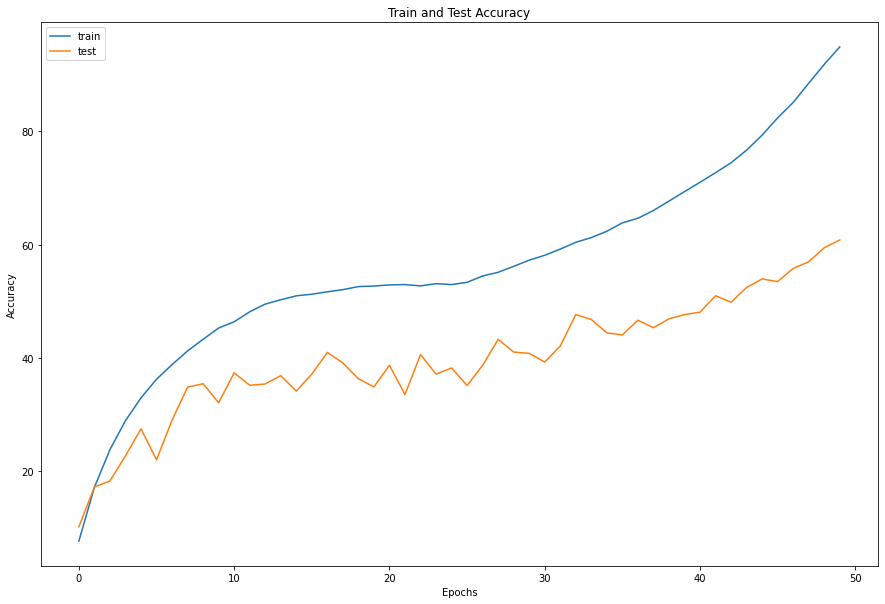

In [ ]:
all_test_acc = {'train':all_train_acc,'test':test.test_acc}
plotGraph(all_test_acc, "Train and Test Accuracy","Epochs", "Accuracy")

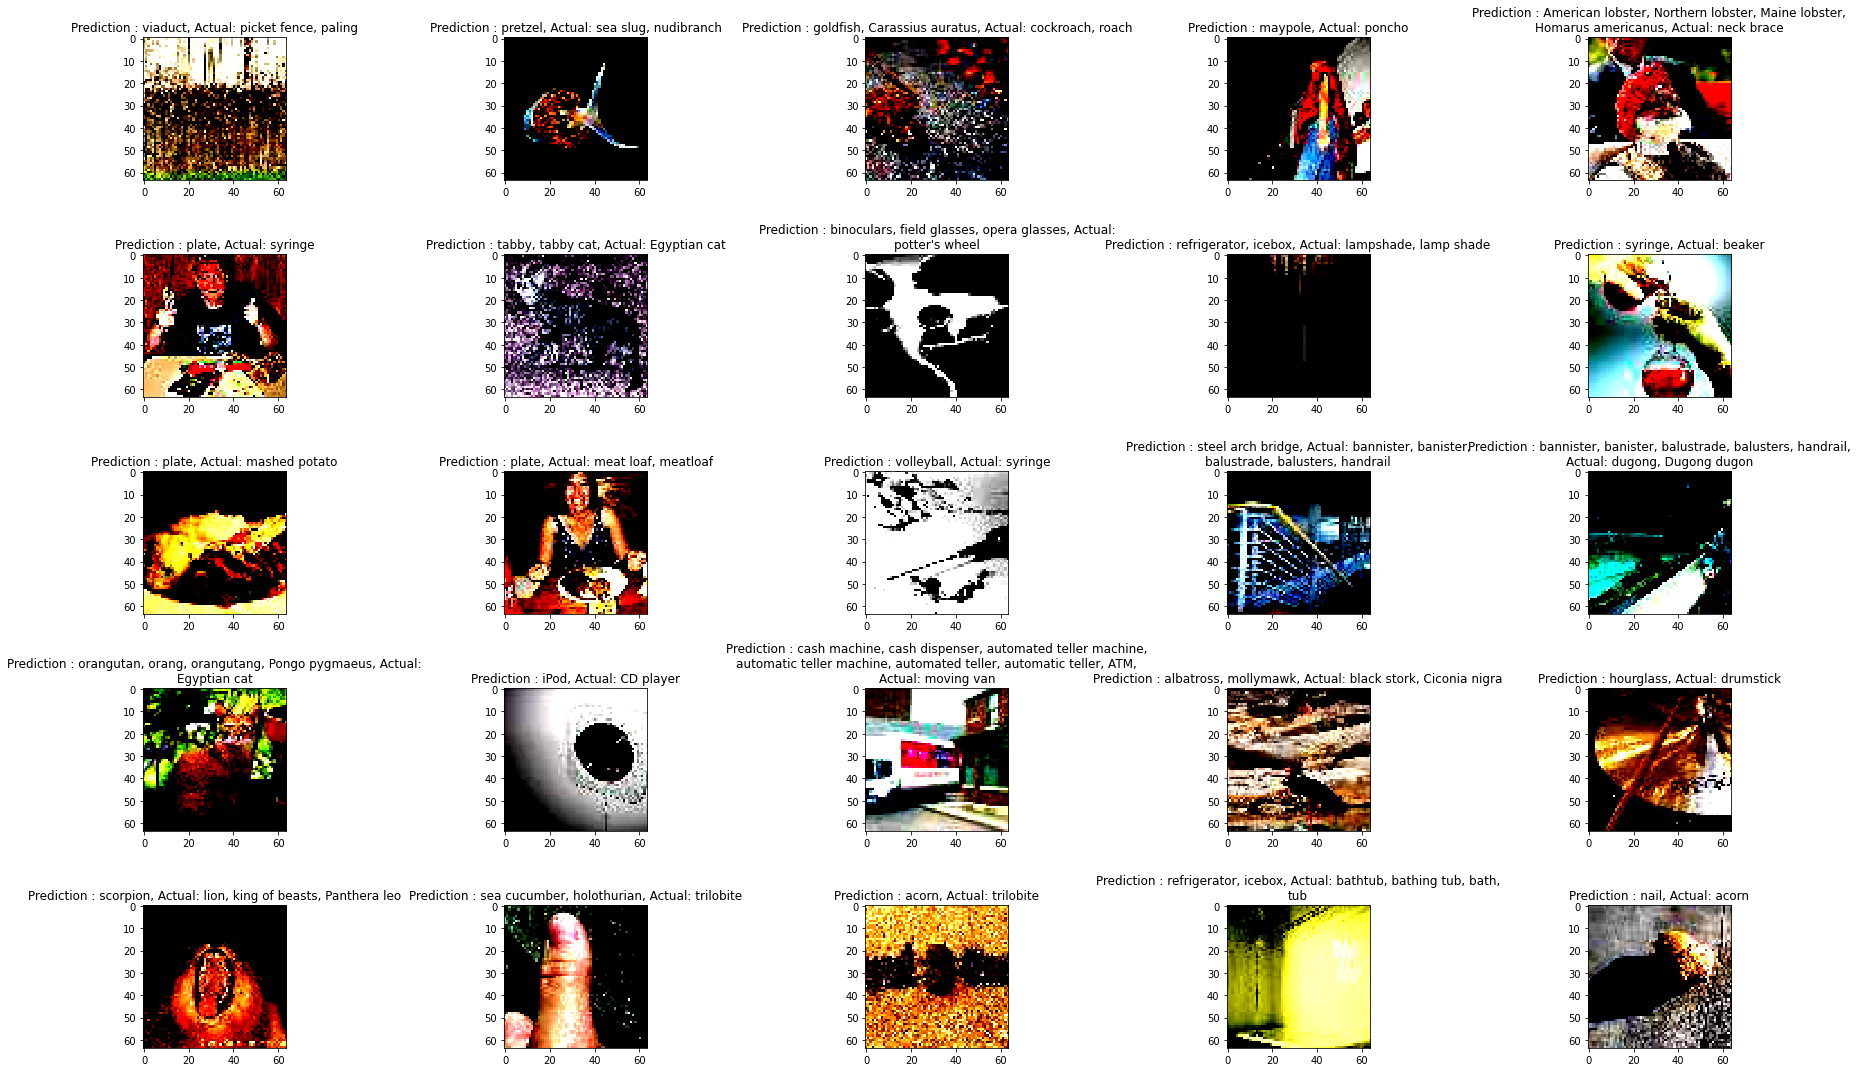

In [10]:
missClassImgs = getMisclassifiedImages(ResNet18(num_classes=200), testloader, device, 'savedModels/'+modelName+'.pt')
plotMisclassifiedImages(missClassImgs, classes)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


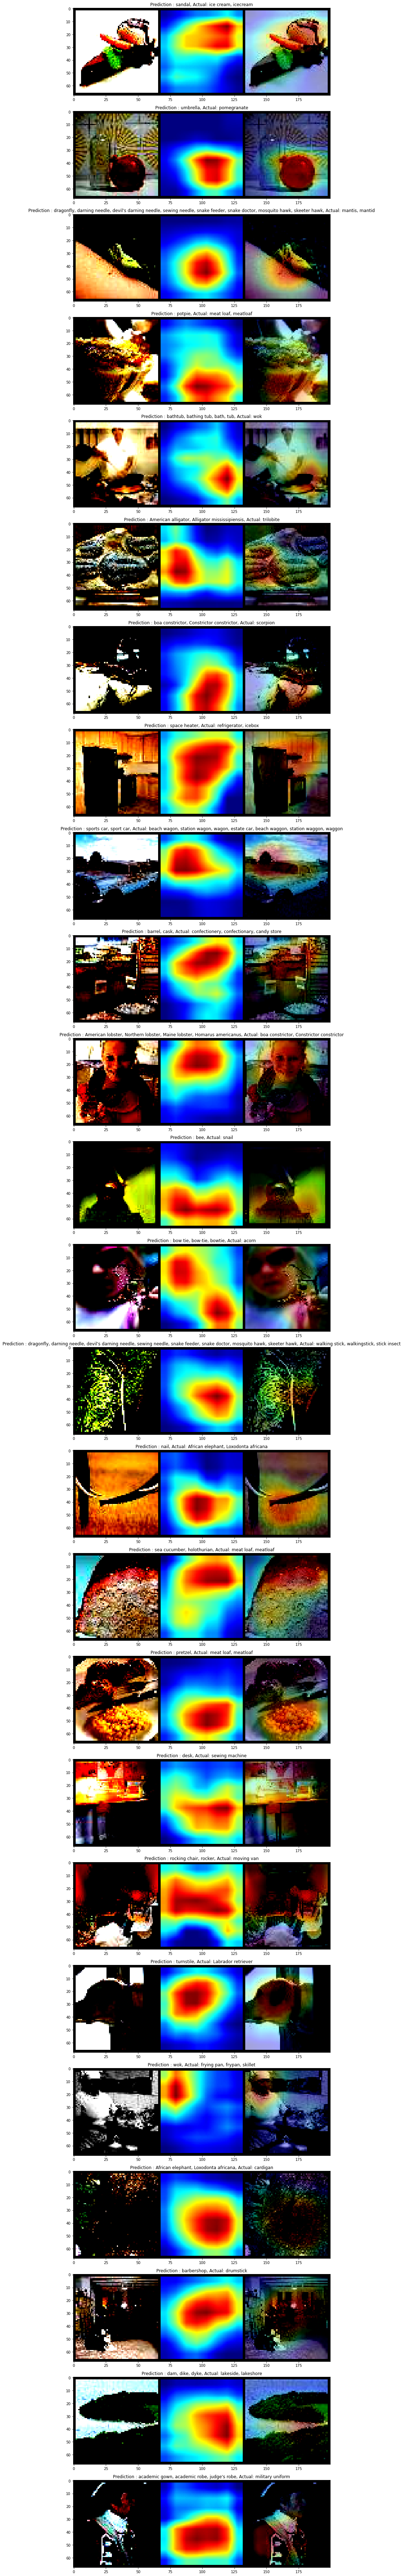

In [ ]:
titles = getPredActualTitle(missClassImgs[:25], classes)
getGradCamOutput(ResNet18(num_classes=200), 'resnet', 'savedModels/'+modelName+'.pt', 'layer4', missClassImgs[:25], titles)